# Time Series Analysis for Top 5 Best Zip Codes for Realty Investments

![header](images/ZipCodeHeader.png)

### by John Nahra, Paul Schulken, and Annie Zheng

# Overview

Our stakeholder is you, a real-estate investment firm, that is interested in buying homes, holding them for 5-year long term and then selling. Our goal is to help you identify which 5 zipcodes would be the best for you to invest in that would maximize your profits.

# Bottom Line

These 5 zipcodes would maximize your profits after 5 years:

1. Nashville, TN
2. St. Petersburg, FL
3. Oakland, CA
4. Denver, CO
5. Pittsburgh, PA

These top performers are spread throughout the country so you can also decide which part of the country you want to focus in as well.

# Data Understanding

We used Zillow's monthly median home price data by zipcode for the period 1996 to 2018. One of the limitations of our data is that it happens to include one of the biggest housing busts of all time. This means a model trained on all the data may underestimate home prices during an expansion. To work around this, we used data only from 2013 onward. In order to narrow our focus down from 15,000 zipcodes, we performed two filters: one to find zipcodes with high returns, and the other to find zipcodes with low downside risk. 

# Data Preparation

In [78]:
# Import libraries and set to ignore warnings

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

In [79]:
# Read in data and preview it

df = pd.read_csv('data/zillow_data.csv')

In [80]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [81]:
# Use pandas melt function to place datetime values in singular column corresponding to zip code
melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
melted = melted.dropna(subset=['value'])

# Renaming columns, removing unnecessary columns, resetting index, and formatting zip codes with leading zeroes
melted = melted.rename(columns={'RegionName': 'ZipCode'})
melted = melted.drop('RegionID', axis=1)
melted.set_index('time', inplace=True)
melted['ZipCode'] = melted['ZipCode'].map("{:05}".format)

In [82]:
# Rename 'RegionName' column to 'zipcode' to avoid confusion

df = df.rename(columns={'RegionName': 'zipcode'})

In [83]:
# Place leading zeroes for any zip codes that are currently only 4 digits

df['zipcode'] = df['zipcode'].astype(str).str.zfill(5)

## 5-Year Return

First, we gathered the top 10 zipcodes with the highest 5-year % return from 2013 to 2018. For Nashville, one of our top zipcodes, this was about 150%. Then we filtered that group down to the top 5 by selecting zipcodes with the lowest downside risk in their 5-year % return from 1996 to 2018. 

In [45]:
# Calculating percent return from April 2013 to April 2018

df['five_year'] = ((df['2018-04']/df['2013-04'])-1)*100

In [46]:
df.head()

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,five_year
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,26.082701
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,53.384175
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,28.315830
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,25.878840
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,7.048458


In [47]:
df[['zipcode','City','State','five_year']].sort_values(by=['five_year'],ascending=False).head(10)

,zipcode,City,State,five_year
7302,80216,Denver,CO,173.872951
1477,94601,Oakland,CA,167.943262
5830,48240,Redford,MI,161.224490
1239,94590,Vallejo,CA,159.379310
2661,33705,Saint Petersburg,FL,159.210526
6105,37210,Nashville,TN,155.932203
2627,33460,Lake Worth,FL,153.647059
6563,15201,Pittsburgh,PA,147.593583
475,11216,New York,NY,147.591761
1835,37207,Nashville,TN,146.683047


In [84]:
# Top 5 zip codes by five-year return

df_top_zip = melted[(melted['ZipCode'] == '33705') |
                    (melted['ZipCode'] == '37207') |
                    (melted['ZipCode'] == '80216') |
                    (melted['ZipCode'] == '15201') |
                    (melted['ZipCode'] == '11216')]

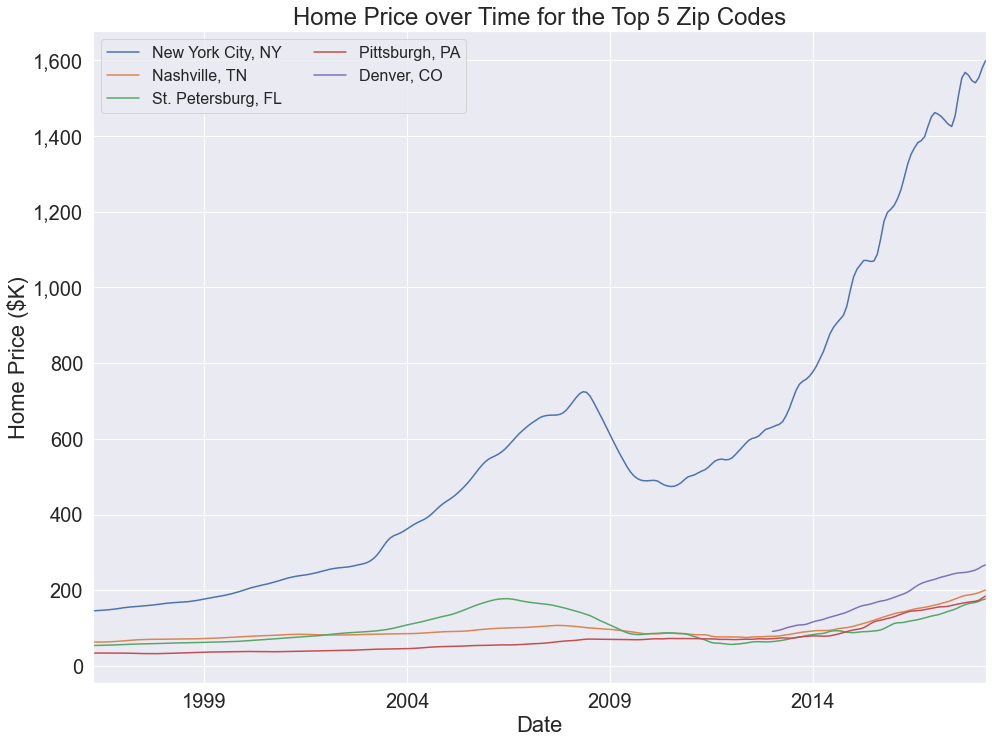

In [85]:
df_top_zip['value'] = df_top_zip['value'] / 1000

#plt.figure()
fig, ax = plt.subplots(figsize=(16,12))

for zipcode in df_top_zip.ZipCode.unique():
    df_top_zip.loc[df_top_zip['ZipCode'] == zipcode].value.plot(label=zipcode)
    
legend_labels = ['New York City, NY', 'Nashville, TN', 'St. Petersburg, FL', 'Pittsburgh, PA', 'Denver, CO']
plt.legend(labels = legend_labels, loc = 'upper left', ncol=2, fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.legend(loc="upper left", ncol=2)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set the title and labels
ax.set_title('Home Price over Time for the Top 5 Zip Codes', fontsize=24)
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel('Home Price ($K)', fontsize=22)
plt.show();

This a chart of home price levels for our top five zipcodes. You can see home prices generally rise over time, but the 2008 financial crisis did create a major reversal of home prices for a time. Yet all these top performers resumed their uptrend and hit new highs as of 2018.

## Down Deviation

To quantify downside risk, we used the down deviation measure, which is essentially a standard deviation calculation that focuses only on downside volatility. We defined downside for these zipcodes as their 5-year % return underperforming the national average for any given month. So on the chart, any month where Nashville's 5-year % return was below that for the national average was included in the down deviation calculation.

In [48]:
dates = list(df.columns[67:])
dates

['2001-04',
 '2001-05',
 '2001-06',
 '2001-07',
 '2001-08',
 '2001-09',
 '2001-10',
 '2001-11',
 '2001-12',
 '2002-01',
 '2002-02',
 '2002-03',
 '2002-04',
 '2002-05',
 '2002-06',
 '2002-07',
 '2002-08',
 '2002-09',
 '2002-10',
 '2002-11',
 '2002-12',
 '2003-01',
 '2003-02',
 '2003-03',
 '2003-04',
 '2003-05',
 '2003-06',
 '2003-07',
 '2003-08',
 '2003-09',
 '2003-10',
 '2003-11',
 '2003-12',
 '2004-01',
 '2004-02',
 '2004-03',
 '2004-04',
 '2004-05',
 '2004-06',
 '2004-07',
 '2004-08',
 '2004-09',
 '2004-10',
 '2004-11',
 '2004-12',
 '2005-01',
 '2005-02',
 '2005-03',
 '2005-04',
 '2005-05',
 '2005-06',
 '2005-07',
 '2005-08',
 '2005-09',
 '2005-10',
 '2005-11',
 '2005-12',
 '2006-01',
 '2006-02',
 '2006-03',
 '2006-04',
 '2006-05',
 '2006-06',
 '2006-07',
 '2006-08',
 '2006-09',
 '2006-10',
 '2006-11',
 '2006-12',
 '2007-01',
 '2007-02',
 '2007-03',
 '2007-04',
 '2007-05',
 '2007-06',
 '2007-07',
 '2007-08',
 '2007-09',
 '2007-10',
 '2007-11',
 '2007-12',
 '2008-01',
 '2008-02',
 '20

In [49]:
dates_offset = list(df.columns[7:-60])
dates_offset

['1996-04',
 '1996-05',
 '1996-06',
 '1996-07',
 '1996-08',
 '1996-09',
 '1996-10',
 '1996-11',
 '1996-12',
 '1997-01',
 '1997-02',
 '1997-03',
 '1997-04',
 '1997-05',
 '1997-06',
 '1997-07',
 '1997-08',
 '1997-09',
 '1997-10',
 '1997-11',
 '1997-12',
 '1998-01',
 '1998-02',
 '1998-03',
 '1998-04',
 '1998-05',
 '1998-06',
 '1998-07',
 '1998-08',
 '1998-09',
 '1998-10',
 '1998-11',
 '1998-12',
 '1999-01',
 '1999-02',
 '1999-03',
 '1999-04',
 '1999-05',
 '1999-06',
 '1999-07',
 '1999-08',
 '1999-09',
 '1999-10',
 '1999-11',
 '1999-12',
 '2000-01',
 '2000-02',
 '2000-03',
 '2000-04',
 '2000-05',
 '2000-06',
 '2000-07',
 '2000-08',
 '2000-09',
 '2000-10',
 '2000-11',
 '2000-12',
 '2001-01',
 '2001-02',
 '2001-03',
 '2001-04',
 '2001-05',
 '2001-06',
 '2001-07',
 '2001-08',
 '2001-09',
 '2001-10',
 '2001-11',
 '2001-12',
 '2002-01',
 '2002-02',
 '2002-03',
 '2002-04',
 '2002-05',
 '2002-06',
 '2002-07',
 '2002-08',
 '2002-09',
 '2002-10',
 '2002-11',
 '2002-12',
 '2003-01',
 '2003-02',
 '20

In [50]:
df_mean = df.copy()

In [51]:
for (i,v) in zip(dates,dates_offset):
    df_mean[f'five-year {i}'] = ((df_mean[i]/df_mean[v])-1)*100
    

In [52]:
df_mean.sort_values(by='five-year 2018-04',ascending=False)

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,five-year 2017-08,five-year 2017-09,five-year 2017-10,five-year 2017-11,five-year 2017-12,five-year 2018-01,five-year 2018-02,five-year 2018-03,five-year 2018-04,five-year five_year
7302,93292,80216,Denver,CO,Denver,Denver,7303,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,176.470588,176.634512,177.578947,173.872951,-99.827678
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,178.811227,178.796095,175.568482,173.752599,177.904564,182.343831,181.440162,176.574803,167.943262,-99.924145
5830,79095,48240,Redford,MI,Detroit,Wayne,5831,67800.0,68200.0,68500.0,...,154.166667,157.954545,155.390335,154.379562,154.480287,154.577465,156.993007,161.458333,161.224490,-99.464370
1239,97795,94590,Vallejo,CA,Vallejo,Solano,1240,108200.0,107800.0,107500.0,...,170.813397,170.259638,170.226033,171.196911,170.940819,168.319763,163.956835,161.505982,159.379310,-99.892818
2661,72768,33705,Saint Petersburg,FL,Tampa,Pinellas,2662,54600.0,54800.0,55000.0,...,139.103555,145.975232,153.115265,158.281250,160.280374,158.769231,160.030395,161.343284,159.210526,-99.772881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14577,85489,62440,Lerna,IL,Charleston,Coles,14578,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14587,74197,37141,Orlinda,TN,Nashville,Robertson,14588,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14623,76460,43013,Hartford,OH,Columbus,Licking,14624,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14707,69681,28039,East Spencer,NC,Charlotte,Rowan,14708,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_mean = df_mean.dropna()

In [54]:
df_mean = df_mean.iloc[:,-205:]

In [55]:
df_mean = df_mean.mean()

In [56]:
df_mean

five-year 2001-05      35.760117
five-year 2001-06      36.308179
five-year 2001-07      36.831948
five-year 2001-08      37.328660
five-year 2001-09      37.806995
                         ...    
five-year 2018-01      34.146081
five-year 2018-02      34.381704
five-year 2018-03      34.759700
five-year 2018-04      34.753288
five-year five_year   -99.976003
Length: 205, dtype: float64

In [57]:
df_mean.to_csv('national.csv')

In [58]:
top_10_zipcodes = list(df[['zipcode','City','State','five_year']].sort_values(by=['five_year'],ascending=False).head(10).iloc[1:10,0].values)
top_10_zipcodes

['94601',
 '48240',
 '94590',
 '33705',
 '37210',
 '33460',
 '15201',
 '11216',
 '37207']

In [59]:
top_10_cities = list(df[['zipcode','City','State','five_year']].sort_values(by=['five_year'],ascending=False).head(10).iloc[1:10,1].values)

In [61]:
top_10_indexes = list(df[['zipcode','City','State','five_year']].sort_values(by=['five_year'],ascending=False).head(10).iloc[1:10].index)

In [62]:
# Down deviation calculation for each city

down_deviation = []
df_mean = pd.read_csv('data/national.csv')
for i in range(0,9):
    city = df.loc[df['zipcode'] == top_10_zipcodes[i]]
    city = city.iloc[:,7:-1]
    city = city.T
    city = city.rename(columns={top_10_indexes[i]:'home price'})
    city.index = city.index.astype('datetime64[ns]')
    city['5 year shift'] = city['home price'].shift(60)
    city['5 year return'] = ((city['home price']/city['5 year shift'])-1)*100
    city_dvar = city.dropna()
    city_dvar['mar'] = df_mean.iloc[:,1].values
    city_dvar['5 year minus mar'] = city_dvar['5 year return'] - city_dvar['mar']
    city_down = city_dvar.loc[city_dvar['5 year minus mar'] < 0]
    city_down['neg sq'] = city_down['5 year minus mar']**2
    dd = np.sqrt(city_down['neg sq'].sum()/city_dvar['mar'].count())
    down_deviation.append(dd)
tuples = tuple(zip(top_10_cities,down_deviation))
sorted_tuples = sorted(tuples, key=lambda x: x[1])

In [63]:
sorted_tuples

[('New York', 0.0),
 ('Pittsburgh', 10.475165014814573),
 ('Nashville', 16.457042623270837),
 ('Nashville', 18.463691341053426),
 ('Saint Petersburg', 20.327570809576375),
 ('Oakland', 20.741096677061226),
 ('Lake Worth', 23.95856075385832),
 ('Vallejo', 27.678102622623772),
 ('Redford', 37.35104365347467)]

These are the top cities by highest 5-year % return and lowest down deviation that we modeled. Denver didn't have data before 2013 so we couldn't calculate its down deviation, but we included it anyway because it had the highest 5-year return. We also excluded a New York City zipcode that would have qualified. We just had a sinking feeling that its expensive home prices could take a hit if a global pandemic were to occur and lead to the rise of remote work.

# Modeling

In [73]:
# Setting up Nashville data to graph against national average

nashville = df.loc[df['zipcode'] == '37210']
nashville = nashville.iloc[:,7:-1]
nashville = nashville.T

nashville = nashville.rename(columns={6105:'home price'})
nashville.index = nashville.index.astype('datetime64[ns]')
nashville['diff'] = nashville.diff()
nashville['home price shifted'] = nashville['home price'].shift()
nashville['pct'] = nashville['diff']/nashville['home price shifted']
nashville['5 year shift'] = nashville['home price'].shift(60)
nashville['5 year return'] = ((nashville['home price']/nashville['5 year shift'])-1)*100

nashville_dvar = nashville.dropna()

In [71]:
nashville_dvar['mar'] = df_mean.iloc[:,1].values
nashville_dvar['5 year minus mar'] = nashville_dvar['5 year return'] - nashville_dvar['mar']
nashville_dvar.head()

,home price,diff,home price shifted,pct,5 year shift,5 year return,mar,5 year minus mar
2001-04-01,78300.0,300.0,78000.0,0.003846,60800.0,28.782895,35.180540,-6.397645
2001-05-01,78500.0,200.0,78300.0,0.002554,61000.0,28.688525,35.760117,-7.071592
2001-06-01,78800.0,300.0,78500.0,0.003822,61200.0,28.758170,36.308179,-7.550009
2001-07-01,79000.0,200.0,78800.0,0.002538,61300.0,28.874388,36.831948,-7.957560
2001-08-01,79200.0,200.0,79000.0,0.002532,61500.0,28.780488,37.328660,-8.548172


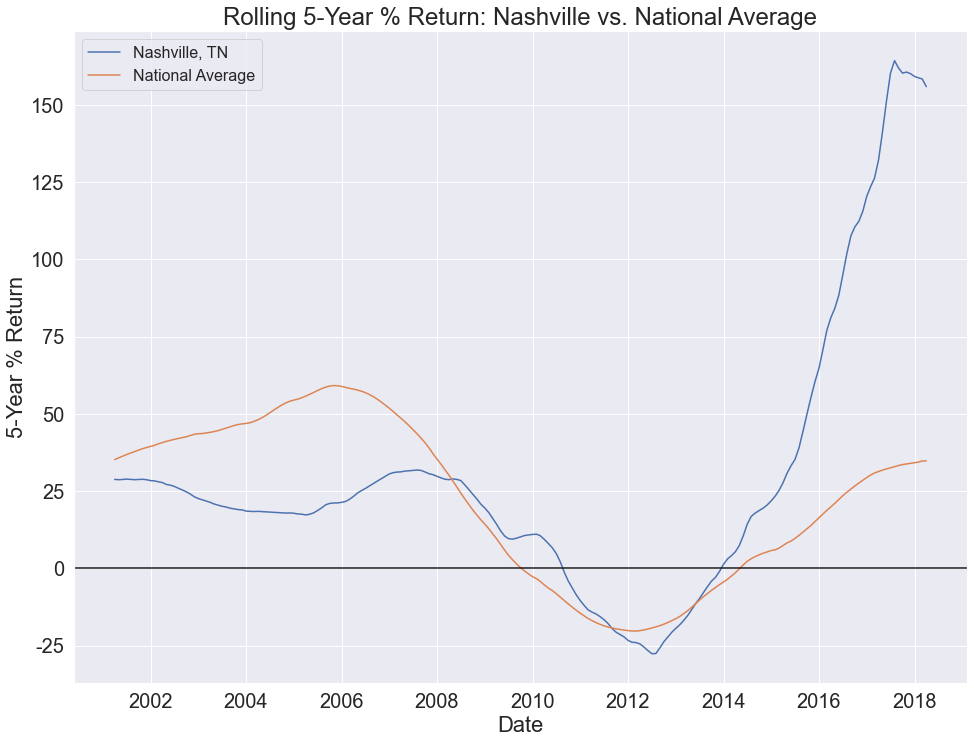

In [72]:
#plt.figure()
fig, ax = plt.subplots(figsize=(16,12))

# Set the title and labels
ax.plot(nashville_dvar[['5 year return','mar']])
ax.set_title('Rolling 5-Year % Return: Nashville vs. National Average', fontsize=24)
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel('5-Year % Return', fontsize=22)

legend_labels = ['Nashville, TN', 'National Average']
plt.legend(labels = legend_labels, loc = 'upper left', ncol=1, fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='k', linestyle='-')

#plt.legend(loc="upper left", ncol=2)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show();

In [24]:
top_5_zipcodes = ['80216','94601','33705','37210','15201']
top_5_cities = ['Denver','Oakland','Saint Petersburg','Nashville','Pittsburgh']
top_5_indexes = [7302,1477,2661,6105,6563]

We split our data into train and test sets. The train set was 2013 to 2017 and the test set was 2017 to 2018. We ran five ARIMA models, one for each of the top zipcodes. Each model used second order differencing to make the data stationary.

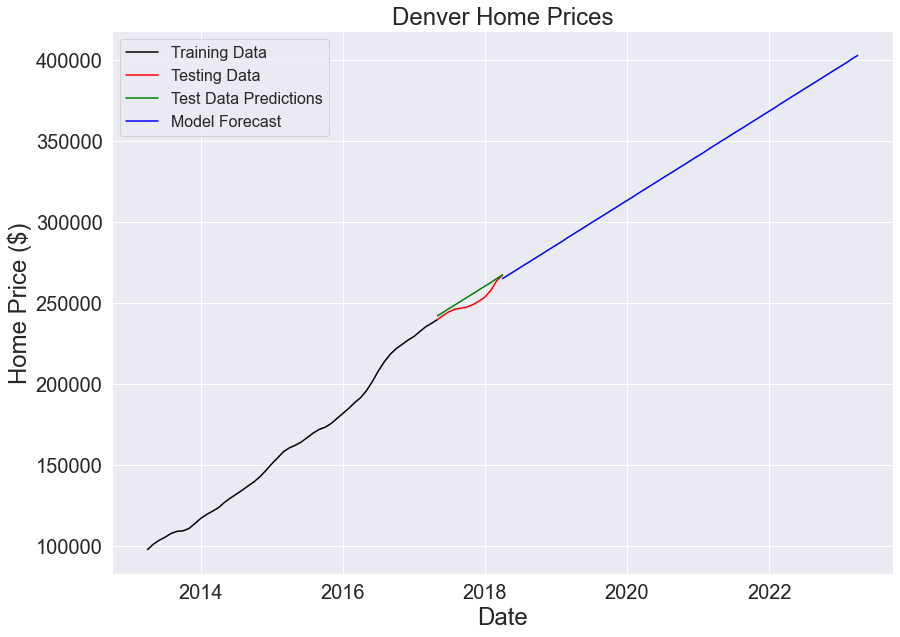

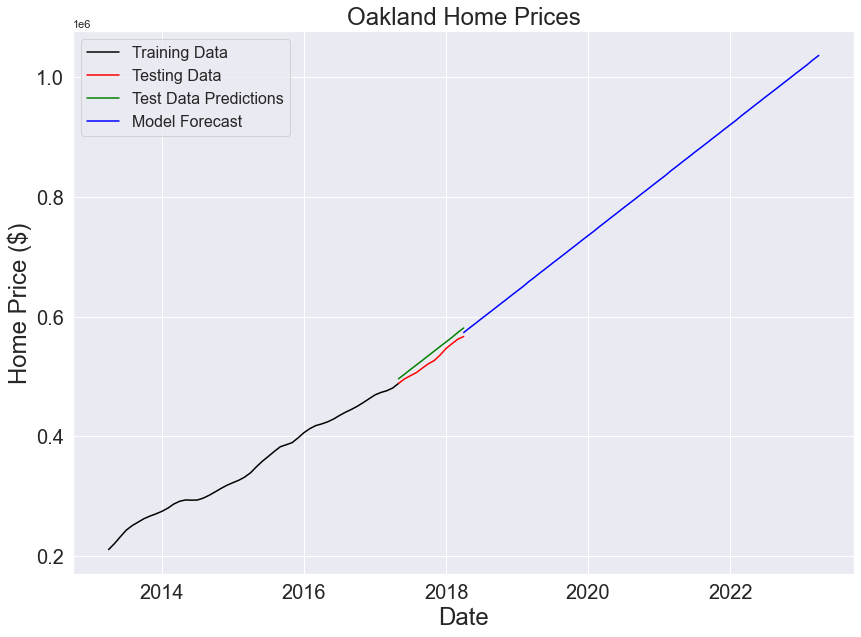

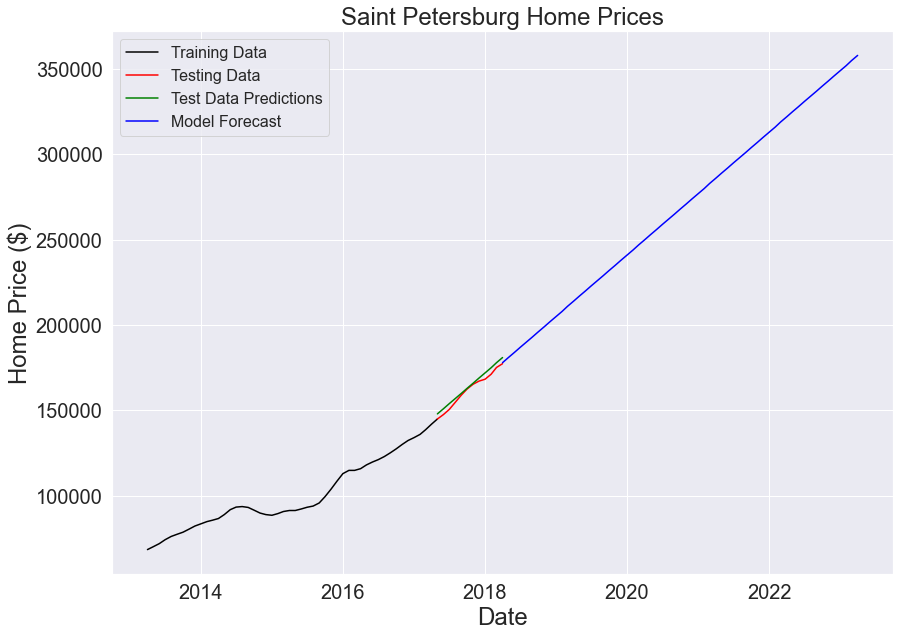

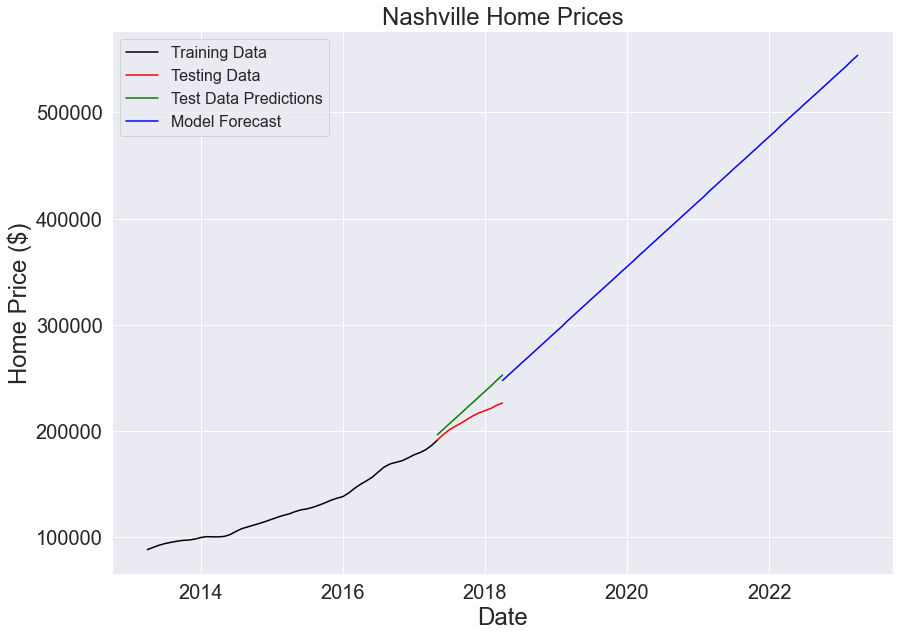

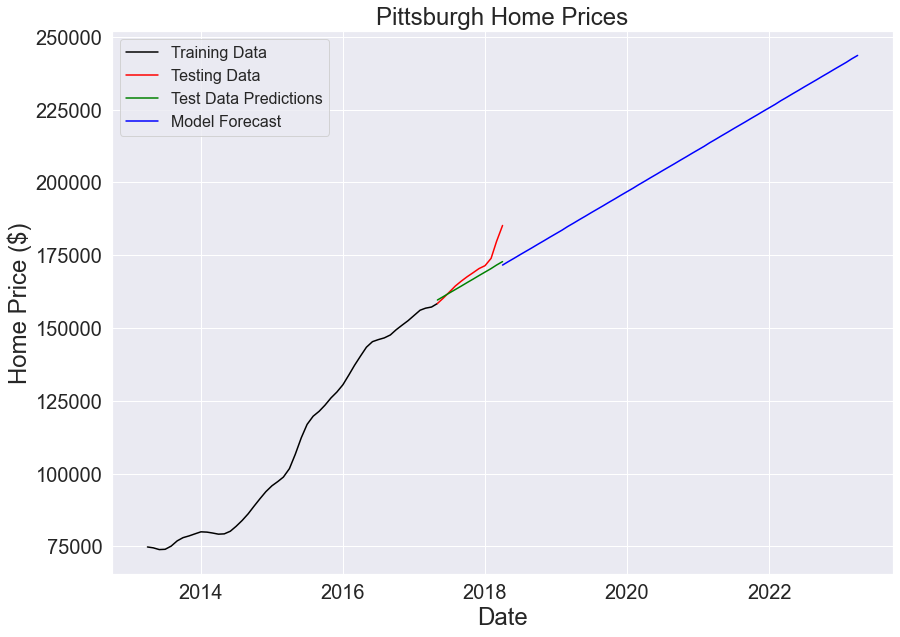

In [25]:
# Running train/test splits and looping through each zip code to produce ARIMA models
# Making predictions and plotting for each zip code

train_errors = []
test_errors = []
one_year = []
three_year = []
five_year = []
for i in range(0,5):
    city = df.loc[df['zipcode'] == top_5_zipcodes[i]]
    city = city.iloc[:,7:-1]
    city = city.T
    city = city.rename(columns={top_5_indexes[i]:'home price'})
    city.index = city.index.astype('datetime64[ns]')
    city = city['2013-04':]
    
    cutoff = '2017-05'
    train = city[:cutoff]
    test = city[cutoff:]
    
    ar_1 = ARIMA(train, order=(0, 2, 0)).fit()
    
    train_pred = ar_1.predict()
    train_error = np.sqrt(mean_squared_error(train, train_pred))
    train_errors.append(train_error)
    
    y_pred = ar_1.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ar_1.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]
    test_error = np.sqrt(mean_squared_error(test, y_pred_out))
    test_errors.append(test_error)
    
    output = ar_1.predict(start='2018-04-01',end='2023-04-01')
    
    sns.set(font_scale = 1)

    plt.figure(figsize=(14,10))
    plt.plot(train, color = "black",label='Training Data')
    plt.plot(test, color = "red",label='Testing Data')
    plt.ylabel('Home Price ($)', fontsize=24)
    plt.xlabel('Date', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(f"{top_5_cities[i]} Home Prices", fontsize=24)
    plt.plot(y_pred_out, color='green', label = 'Test Data Predictions')
    plt.plot(output, color='blue', label = 'Model Forecast')
    plt.legend(fontsize=16);

    pred1 = output[12]
    pred3 = output[36]
    pred5 = output[-1]
    actual = test['home price'][-1]
    change1 = ((pred1-actual)/actual) * 100
    change3 = ((pred3-actual)/actual) * 100
    change5 = ((pred5-actual)/actual) * 100
    one_year.append(change1)
    three_year.append(change3)
    five_year.append(change5)

In [74]:
top_5_cities_sorted = ['Nashville','St. Petersburg','Oakland','Denver','Pittsburgh']

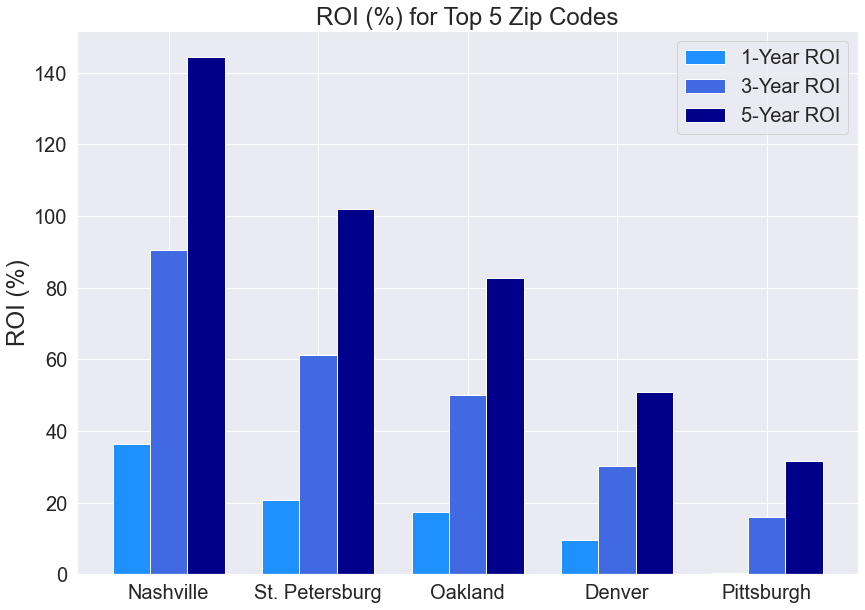

In [86]:
plt.figure(figsize=(14,10))

# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(one_year))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, sorted(one_year,reverse=True), color='dodgerblue', width=barWidth, edgecolor='white', label='1-Year ROI')
plt.bar(r2, sorted(three_year,reverse=True), color='royalblue', width=barWidth, edgecolor='white', label='3-Year ROI')
plt.bar(r3, sorted(five_year,reverse=True), color='darkblue', width=barWidth, edgecolor='white', label='5-Year ROI')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(one_year))], top_5_cities_sorted)

plt.ylabel('ROI (%)', fontsize=24)
plt.title('ROI (%) for Top 5 Zip Codes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=16);
 
# Create legend & Show graphic
plt.legend(fontsize=20)
plt.show()

Nashville had the highest predicted 5 year return of our top zipcodes. Our model has an implicit assumption that there will not be a housing recession in the next five years.

# Evaluation

In [28]:
train_errors

[15908.69643858733,
 37525.90706870076,
 11340.157390819606,
 14539.733453562305,
 12400.606807693952]

In [29]:
from statistics import mean
mean(train_errors)

18343.02023187279

In [30]:
test_errors

[4469.712891599787,
 12067.760079374024,
 2748.4844308576075,
 15164.157301566964,
 4629.344806053372]

In [31]:
mean(test_errors)

7815.891901890351

# Recommendations

After the top 5 zip codes were selected for modeling and predictions made based off of those models, we were able to calculate return on investment at various intervals. Although the main focus of our analysis was to find the best five year return, we have included one and three year returns as well. From the chart you can see that Nashville has the highest predicted returns for each time interval, most notably a 144% five year return! St. Petersburg and Oakland were strong performers as well.

With the highest returns across all three time intervals, our first recommendation is to explore acquiring property in Nashville, TN. We also found St. Petersburg, Oakland, and Denver produce hefty returns. Lastly, although Pittsburgh didn't perform as well as the others, it rounds out our Top 5 in terms of maximum return and minimum risk . With a variety of geographic features including beaches, mountains, and more dense urban areas, your investment may also depend on personal preference and lifestyle.

## Future Insights

Future models could be made more comprehensive by including extra variables like mortgage rates and analyzing any cyclical trends like recession indicators. In addition, we could investigate seasonality to determine if a certain time of year was the best time to buy or sell.